In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#reading the data
data = pd.read_csv('cumulative.csv')
data
data = data.sample(n = 9000)
#from google.colab import drive
#drive.mount('/content/drive')

#selecting important columns after comparing the correlation matrix coded below
xdata = data.drop(columns=['koi_disposition','koi_pdisposition', 'koi_tce_plnt_num', 'koi_tce_delivname', 'kepler_name', 'kepoi_name','koi_period_err1', 'koi_period_err2', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol_err1', 'koi_insol_err2', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad_err1', 'koi_srad_err2'])

#cleaning the data
data = data.dropna(axis = "columns")
xdata = xdata.dropna(axis = "columns")
xdata


rowid     kepid  koi_fpflag_nt  ...  koi_duration         ra        dec
9004   9005   5709226              1  ...        7.2800  292.96835  40.954239
5028   5029  11519134              0  ...        3.5939  297.03964  49.469139
1142   1143   5553652              0  ...        6.1580  296.99191  40.758911
1355   1356   9634821              0  ...        1.5300  284.34274  46.316551
8740   8741   6778289              0  ...       13.4919  292.10236  42.252239
...     ...       ...            ...  ...           ...        ...        ...
5645   5646   2014991              0  ...        2.5270  291.54935  37.403580
3376   3377   5309353              0  ...        1.7450  299.68130  40.428425
1256   1257   4770365              0  ...        1.6067  297.43039  39.847839
6190   6191   5015027              1  ...        1.2200  292.94348  40.117939
5348   5349  12557548              0  ...        1.6300  290.96622  51.504719

[9000 rows x 11 columns]

In [ ]:
# using code and analysis of the features from lab 2

#scaling the xdata
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

xdata = pd.DataFrame(scaler.fit_transform(xdata), columns=xdata.columns, index=xdata.index)

import numpy as np

ydata = data['koi_disposition']

yvaild = np.asarray(ydata[6001:8000])
xvalid = np.asarray(xdata[6001:8000]).astype(np.float64)
xtrain = np.asarray(xdata[0:6000]).astype(np.float64)
ytrain = np.asarray(ydata[0:6000])
ytest = np.asarray(ydata[8001:9000])
xtest = np.asarray(xdata[8001:9000]).astype(np.float64)
ytrain


#converting the Ydata where confirm:1 and false:0

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(categories=[['CONFIRMED']],handle_unknown='ignore', dtype = int) 


ytrain = ytrain.reshape(-1,1)
ytest = ytest.reshape(-1,1)
yvalid = yvaild.reshape(-1,1)
ytrain_em = cat_encoder.fit_transform(ytrain).toarray()
ytest_em = cat_encoder.fit_transform(ytest).toarray()
print(ytrain_em)
yvalid_em = cat_encoder.fit_transform(yvalid).toarray()
yvalid_em

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [ ]:
xtrain.shape

(6000, 11)

In [ ]:
xvalid.shape

(1999, 11)

In [ ]:
ytrain_em.shape

(4000, 1)

In [ ]:
xtest.shape

(2999, 11)

In [ ]:
#used from ch10 ex10
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[11]),
    keras.layers.Dense(36, activation="relu"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

We will start with a small learning rate of 1e-3, and grow it by 1% at each iteration:

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.01)
expon_lr

Now let's train the model for just 1 epoch:

In [ ]:
history = model.fit(xtrain, ytrain_em, epochs=1,
                    validation_data=(xvalid, yvalid_em), callbacks=[expon_lr])


188/188 [==============================] - 1s 4ms/step - loss: 0.6130 - accuracy: 0.7639 - val_loss: 0.5109 - val_accuracy: 0.7714


We can now plot the loss as a functionof the learning rate:

Text(0, 0.5, 'Loss')

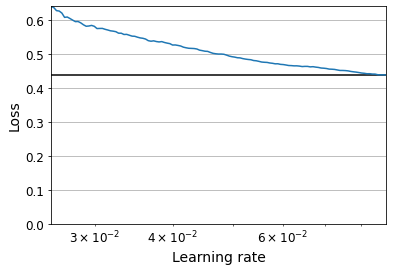

In [ ]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[11]),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(xtrain, ytrain_em, epochs=100,
                    validation_data=(xvalid, yvalid_em),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch 1/100
125/125 [==============================] - 1s 6ms/step - loss: 0.5644 - accuracy: 0.7521 - val_loss: 0.4627 - val_accuracy: 0.7659
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 0.4646 - accuracy: 0.7536 - val_loss: 0.3935 - val_accuracy: 0.7659
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 0.3737 - accuracy: 0.7790 - val_loss: 0.3391 - val_accuracy: 0.7704
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.3410 - accuracy: 0.8027 - val_loss: 0.3028 - val_accuracy: 0.8549
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 0.3179 - accuracy: 0.8481 - val_loss: 0.2831 - val_accuracy: 0.8779
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.2998 - accuracy: 0.8637 - val_loss: 0.2713 - val_accuracy: 0.8724
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 0.2985 - accuracy: 0.8614 - val_loss: 0.2649 - val_accuracy: 0.8789

In [ ]:
model = keras.models.load_model("my_model.h5") # rollback to best model
model.evaluate(xtest, ytest_em)

94/94 [==============================] - 0s 2ms/step - loss: 0.3009 - accuracy: 0.8553


[0.3008919060230255, 0.855285108089447]

We got over 85% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [ ]:
%tensorboard --logdir=./my_mnist_logs --port=6006

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def build_model(n_hidden=3, n_neurons=36, learning_rate=3e-3, input_shape=[11]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer, metrics = ["accuracy"])
    return model

In [ ]:
keras_clas = keras.wrappers.scikit_learn.KerasClassifier(build_model)


In [ ]:
keras_clas.fit(xtrain, ytrain_em, epochs=100,
              validation_data=(xvalid, yvalid_em),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
125/125 [==============================] - 1s 4ms/step - loss: 0.2830 - accuracy: 0.2424 - val_loss: 0.2584 - val_accuracy: 0.2541
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 0.2515 - accuracy: 0.4461 - val_loss: 0.2343 - val_accuracy: 0.7659
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 0.2282 - accuracy: 0.7790 - val_loss: 0.2166 - val_accuracy: 0.7659
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.2144 - accuracy: 0.7550 - val_loss: 0.2029 - val_accuracy: 0.7659
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 0.2022 - accuracy: 0.7555 - val_loss: 0.1925 - val_accuracy: 0.7659
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1933 - accuracy: 0.7557 - val_loss: 0.1845 - val_accuracy: 0.7659
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1866 - accuracy: 0.7548 - val_loss: 0.1785 - val_accuracy: 0.7659

In [ ]:
mse_test = keras_clas.score(xtest, ytest_em)


94/94 [==============================] - 0s 2ms/step - loss: 0.1013 - accuracy: 0.8526


In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 50)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_clas, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(xtrain, ytrain_em, epochs=100,
                  validation_data=(xvalid, yvalid_em),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=1, n_hidden=3, learning_rate=0.009513728598785756 .....
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


84/84 [==============================] - 1s 6ms/step - loss: 0.2467 - accuracy: 0.7625 - val_loss: 0.2373 - val_accuracy: 0.7659
Epoch 2/100
84/84 [==============================] - 0s 4ms/step - loss: 0.2348 - accuracy: 0.7627 - val_loss: 0.2270 - val_accuracy: 0.7659
Epoch 3/100
84/84 [==============================] - 0s 4ms/step - loss: 0.2263 - accuracy: 0.7520 - val_loss: 0.2187 - val_accuracy: 0.7659
Epoch 4/100
84/84 [==============================] - 0s 4ms/step - loss: 0.2167 - accuracy: 0.7678 - val_loss: 0.2120 - val_accuracy: 0.7659
Epoch 5/100
84/84 [==============================] - 0s 4ms/step - loss: 0.2119 - accuracy: 0.7580 - val_loss: 0.2065 - val_accuracy: 0.7659
Epoch 6/100
84/84 [==============================] - 0s 4ms/step - loss: 0.2043 - accuracy: 0.7705 - val_loss: 0.2021 - val_accuracy: 0.7659
Epoch 7/100
84/84 [==============================] - 0s 4ms/step - loss: 0.2011 - accuracy: 0.7662 - val_loss: 0.1984 - val_accuracy: 0.7659
Epoch 8/100
84/84 [======

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.6s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
84/84 [==============================] - 0s 4ms/step - loss: 0.1979 - accuracy: 0.7597 - val_loss: 0.1955 - val_accuracy: 0.7659
Epoch 39/100
84/84 [==============================] - 0s 4ms/step - loss: 0.1975 - accuracy: 0.7580 - val_loss: 0.1947 - val_accuracy: 0.7659
Epoch 40/100
84/84 [==============================] - 0s 4ms/step - loss: 0.1966 - accuracy: 0.7586 - val_loss: 0.1940 - val_accuracy: 0.7659
Epoch 41/100
84/84 [==============================] - 0s 4ms/step - loss: 0.1961 - accuracy: 0.7586 - val_loss: 0.1932 - val_accuracy: 0.7659
Epoch 42/100
84/84 [==============================] - 0s 4ms/step - loss: 0.1969 - accuracy: 0.7535 - val_loss: 0.1925 - val_accuracy: 0.7659
Epoch 43/100
84/84 [==============================] - 0s 4ms/step - loss: 0.1939 - accuracy: 0.7610 - val_loss: 0.1919 - val_accuracy: 0.7659
Epoch 44/100
84/84 [==============================] - 0s 4ms/step - loss: 0.1929 - accuracy: 0.7635 - val_loss

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 19.8min finished


125/125 [==============================] - 1s 3ms/step - loss: 0.2353 - accuracy: 0.6264 - val_loss: 0.1757 - val_accuracy: 0.7659
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 0.1732 - accuracy: 0.7536 - val_loss: 0.1543 - val_accuracy: 0.7659
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1478 - accuracy: 0.7790 - val_loss: 0.1467 - val_accuracy: 0.7659
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1501 - accuracy: 0.7550 - val_loss: 0.1408 - val_accuracy: 0.7659
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1456 - accuracy: 0.7555 - val_loss: 0.1354 - val_accuracy: 0.7659
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1396 - accuracy: 0.7557 - val_loss: 0.1302 - val_accuracy: 0.7659
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1356 - accuracy: 0.7548 - val_loss: 0.1254 - val_accuracy: 0.7659
Epoch 8/100

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f65c8094650>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.00039200...
                                                          0.0024505367684280487,
                                                          0.011155092541719619,
                                                          0.0007

In [ ]:
rnd_search_cv.best_params_

{'learning_rate': 0.02553730574228662, 'n_hidden': 1, 'n_neurons': 25}

In [ ]:
rnd_search_cv.best_score_

0.8737493554751078

In [ ]:
rnd_search_cv.best_score_

0.8737493554751078

In [ ]:
rnd_search_cv.score(xtest, ytest_em)

94/94 [==============================] - 0s 2ms/step - loss: 0.0978 - accuracy: 0.8556


0.8556185364723206

In [ ]:
model = rnd_search_cv.best_estimator_.model
model

In [ ]:
model.evaluate(xtest, ytest_em)

94/94 [==============================] - 0s 2ms/step - loss: 0.0978 - accuracy: 0.8556


[0.0977926179766655, 0.8556185364723206]

**Building a model with new parameters**

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[11]),
    keras.layers.Dense(36, activation="relu"),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.02553),
              metrics=["accuracy"])

model.fit(xtrain, ytrain_em, epochs=1, validation_data=(xvalid, yvalid_em))

ytest_pred = model.predict(xtest)
#87% accuracy

188/188 [==============================] - 1s 3ms/step - loss: 0.3153 - accuracy: 0.8452 - val_loss: 0.2939 - val_accuracy: 0.8744


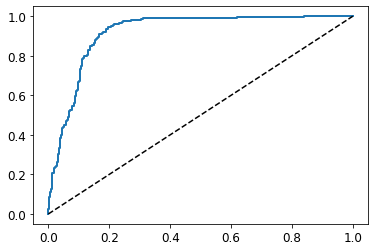

In [ ]:
#roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(ytest_em, ytest_pred, pos_label=1)

def plot_roc_curve(tpr, fpr, label = None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  [...]

plot_roc_curve(tpr,fpr)
plt.show()

#Some notes made while doing the assignment and sources of error
- Since the shape of our testing and trainng array data was different (from lab2), we changed the input shape to 11 while flattening the kelars layers. 
- The next change we changed our output shape and used OneHotEncoder, to get 1 for confirms and 0 for candidate and not a planet. 
- We often were getting a ternflow error while running our model so we changed the density to 36,20 and 1. 
- Since sigmoid is used for binary classification we changed our activation function from softmax to sigmoid. 
- While building out neural model we changed o the number of neurons from 300 to 36. 
- Since we are doing binary configuration we changed the loss from sparse_categorical_crossentropy to binary_crossentropy while compiling our model. 
- We used code from Ch10 modules to tune Hyperpyrameters  we changed the KerasRegresor to KerasClassifier. 
- We plotted ROC curve.